# 224x224 Retina Fotoğraflarından Diyabetik Retinopati Tespiti ve Sınıflandırma projesi

# Diabetic Retinopathy Detection and Classification Project from 224x224 Retinal Photos

*İsmail DUMLU 240711003* \
*M. Mirza ERDEM 240711012* \
*M Selçuk İNCİ 240711020*

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetic-retinopathy-224x224-2019-data' dataset.
Path to dataset files: /kaggle/input/diabetic-retinopathy-224x224-2019-data


In [12]:
!ls -l {path}

total 56
drwxr-sr-x 7 1000 1000     0 Dec 18 12:47 colored_images
-rw-r--r-- 1 1000 1000 54948 Dec 18 12:47 train.csv


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("/kaggle/input/diabetic-retinopathy-224x224-2019-data/train.csv")

df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [15]:
import cv2

In [16]:
def crop_image_from_gray(img,tol=7):
  if img.ndim ==2:
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]
  elif img.ndim==3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img>tol
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
      return img
    else:
      img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
      img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
      img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
      img = np.stack([img1,img2,img3],axis=-1)
    return img

def preprocess_image(image, sigmaX=10):
  image = np.array(image, dtype=np.uint8)
  image = crop_image_from_gray(image)
  image = cv2.resize(image, (224, 224))
  weighted = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)
  return weighted.astype(np.float32) # Ensure output is float32

In [17]:
from sklearn.model_selection import train_test_split
x = df['id_code']
y = df['diagnosis']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42, stratify=y)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [19]:
!ls -l {data_dir}

ls: cannot access '{data_dir}': No such file or directory


In [20]:
diagnosis_map = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}
print(diagnosis_map)

{0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}


In [21]:
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=None, # Explicitly set to None
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
    preprocessing_function=preprocess_image

)

validation_datagen = ImageDataGenerator(
    rescale=None, # Explicitly set to None
    preprocessing_function=preprocess_image
    )

In [22]:
train_df = pd.DataFrame({'id_code': x_train, 'diagnosis': y_train})
val_df = pd.DataFrame({'id_code': x_test, 'diagnosis': y_test})

train_df['folder_name'] = train_df['diagnosis'].map(diagnosis_map)
val_df['folder_name'] = val_df['diagnosis'].map(diagnosis_map)

# 'diagnosis' sütununu string'e dönüştürme satırlarını kaldırıyoruz, böylece integer kalır.
# train_df['diagnosis'] = train_df['diagnosis'].astype(str)
# val_df['diagnosis'] = val_df['diagnosis'].astype(str)

train_df['id_code'] = train_df['folder_name'] + '/' + train_df['id_code'] + '.png'
val_df['id_code'] = val_df['folder_name'] + '/' + val_df['id_code'] + '.png'

display(train_df.head())
display(val_df.head())

,id_code,diagnosis,folder_name
2579,No_DR/b2b79b37d314.png,0,No_DR
309,Moderate/175dd560810a.png,2,Moderate
2826,Severe/c3cd0200df79.png,3,Severe
2989,No_DR/cfed7c1172ec.png,0,No_DR
3344,Moderate/e811f39a1243.png,2,Moderate


,id_code,diagnosis,folder_name
1595,No_DR/6fe67fd7f5d1.png,0,No_DR
3449,No_DR/ef8c39eb9157.png,0,No_DR
1394,Proliferate_DR/61bbc11fe503.png,4,Proliferate_DR
1379,No_DR/60edda7b4871.png,0,No_DR
3043,No_DR/d30d079e6f9a.png,0,No_DR


In [23]:
from numpy.random import shuffle
data_dir = path + '/colored_images'
img_size = image_size[0]

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw' # 'categorical' yerine 'raw' kullanıyoruz
)

validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False # 'categorical' yerine 'raw' kullanıyoruz
)

class_names = list(diagnosis_map.values())
print("Classes:", class_names)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


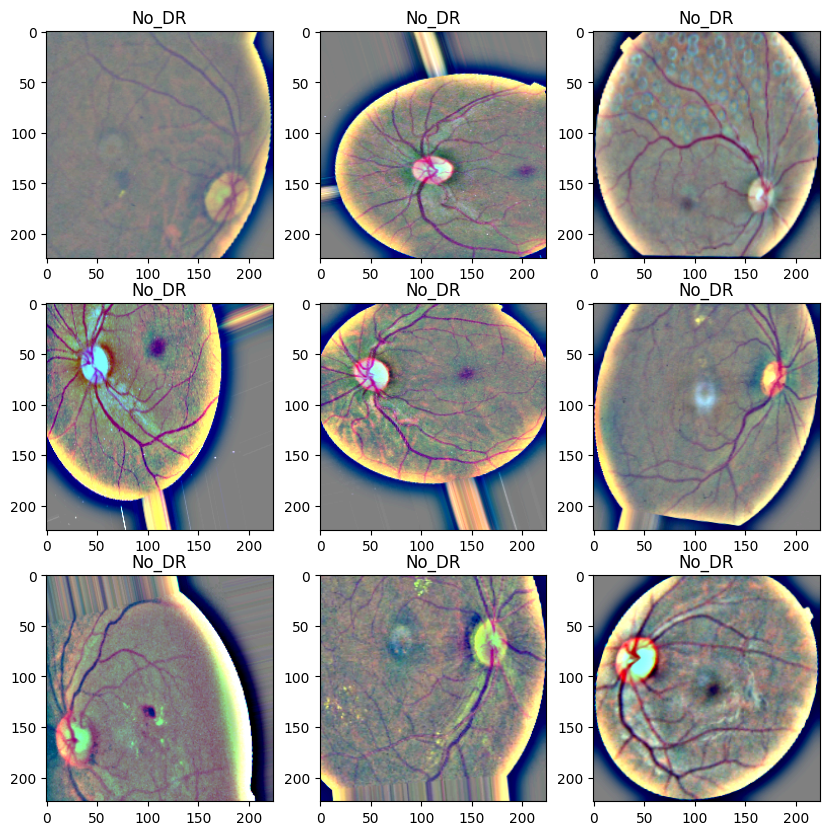

In [24]:
images, labels = next(train_generator)


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    label_index = np.argmax(labels[i]) # Düzeltilen kısım: one-hot encoded etiketten indeksi al
    plt.title(class_names[label_index])

    plt.imshow(images[i]/255)


plt.show()

In [25]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

In [26]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)

)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
from sklearn.utils import class_weight

# 1. Ağırlıkları Hesapla
# 'balanced' modu, az olan sınıfa otomatik olarak yüksek puan verir.
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train), # Sınıfları bul (0, 1, 2, 3, 4)
    y=y_train                   # Eğitim verisindeki dağılıma bak
)

# 2. Sözlük Formatına Çevir (Keras bu formatı ister)
class_weights = dict(enumerate(weights))

# Kontrol için ekrana yazdır
print("Hesaplanan Sınıf Ağırlıkları:", class_weights)

Hesaplanan Sınıf Ağırlıkları: {0: np.float64(0.4056786703601108), 1: np.float64(1.979054054054054), 2: np.float64(0.7331664580725907), 3: np.float64(3.803896103896104), 4: np.float64(2.4822033898305085)}


In [31]:
# Ustanın (EfficientNet) bilgilerini kilitliyoruz
base_model.trainable = False

# Kendi katmanlarını ekle (Çırak)
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# ==========================================
# Sadece senin eklediğin katmanlar hızlıca eğitilir
# ==========================================
print("\n--- 1. AŞAMA: ISINMA TURU BAŞLIYOR (Sadece son katmanlar) ---")

model.compile(
    optimizer=Adam(learning_rate=0.0001), # Yüksek hız
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Kısa bir eğitim (3-5 Epoch yeterli)
history_warmup = model.fit(
    train_generator,
    epochs=4,
    validation_data=validation_generator,
    class_weight=class_weights, # Sınıf ağırlıkları
    verbose=1
)



# Kilidi açıp tüm modeli yavaşça eğitiyoruz
# ==========================================
print("\n--- 2. AŞAMA: İNCE AYAR BAŞLIYOR (Tüm Model) ---")

base_model.trainable = True # Kilidi açtık!

# Modeli TEKRAR derliyoruz (Önemli!). Hızı çok düşürüyoruz.
model.compile(
    optimizer=Adam(learning_rate=0.00001), # Çok düşük hız (1e-5)
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] # AUC metriği kaldırıldı
)

# Callbacks tanımları (2. aşama için kritik)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_diabetic_model.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

# Asıl uzun eğitim
history_finetune = model.fit(
    train_generator,
    epochs=100, # Burayı istersen 20 yapabilirsin
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights, # Sınıf ağırlıkları
    verbose=1
)


--- 1. AŞAMA: ISINMA TURU BAŞLIYOR (Sadece son katmanlar) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.3201 - loss: 1.6033 - val_accuracy: 0.5825 - val_loss: 1.0727
Epoch 2/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 907ms/step - accuracy: 0.5656 - loss: 1.2996 - val_accuracy: 0.6057 - val_loss: 0.9718
Epoch 3/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 915ms/step - accuracy: 0.5860 - loss: 1.2296 - val_accuracy: 0.6003 - val_loss: 0.9500
Epoch 4/4
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 907ms/step - accuracy: 0.6280 - loss: 1.1303 - val_accuracy: 0.6112 - val_loss: 0.8811

--- 2. AŞAMA: İNCE AYAR BAŞLIYOR (Tüm Model) ---
Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3098 - loss: 1.5178

92/92 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.3103 - loss: 1.5174 - val_accuracy: 0.6057 - val_loss: 0.9378 - learning_rate: 1.0000e-05
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 931ms/step - accuracy: 0.4443 - loss: 1.4416 - val_accuracy: 0.6057 - val_loss: 0.9447 - learning_rate: 1.0000e-05
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.5263 - loss: 1.3218

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 947ms/step - accuracy: 0.5264 - loss: 1.3218 - val_accuracy: 0.6085 - val_loss: 0.9256 - learning_rate: 1.0000e-05
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.5461 - loss: 1.2461

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 941ms/step - accuracy: 0.5462 - loss: 1.2464 - val_accuracy: 0.6207 - val_loss: 0.9009 - learning_rate: 1.0000e-05
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.5814 - loss: 1.2283

92/92 ━━━━━━━━━━━━━━━━━━━━ 88s 947ms/step - accuracy: 0.5814 - loss: 1.2284 - val_accuracy: 0.6262 - val_loss: 0.8774 - learning_rate: 1.0000e-05
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.5952 - loss: 1.2124

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 950ms/step - accuracy: 0.5950 - loss: 1.2125 - val_accuracy: 0.6303 - val_loss: 0.8481 - learning_rate: 1.0000e-05
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.5925 - loss: 1.1839

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 947ms/step - accuracy: 0.5925 - loss: 1.1839 - val_accuracy: 0.6412 - val_loss: 0.8295 - learning_rate: 1.0000e-05
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.6208 - loss: 1.1366

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 949ms/step - accuracy: 0.6207 - loss: 1.1367 - val_accuracy: 0.6385 - val_loss: 0.8146 - learning_rate: 1.0000e-05
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.6321 - loss: 1.1073

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 947ms/step - accuracy: 0.6321 - loss: 1.1073 - val_accuracy: 0.6453 - val_loss: 0.7985 - learning_rate: 1.0000e-05
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.6260 - loss: 1.1395

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 948ms/step - accuracy: 0.6262 - loss: 1.1390 - val_accuracy: 0.6467 - val_loss: 0.7871 - learning_rate: 1.0000e-05
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6686 - loss: 1.0368

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 943ms/step - accuracy: 0.6684 - loss: 1.0373 - val_accuracy: 0.6521 - val_loss: 0.7670 - learning_rate: 1.0000e-05
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.6577 - loss: 1.0248

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 948ms/step - accuracy: 0.6577 - loss: 1.0252 - val_accuracy: 0.6603 - val_loss: 0.7564 - learning_rate: 1.0000e-05
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.6702 - loss: 1.0272

92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 943ms/step - accuracy: 0.6701 - loss: 1.0275 - val_accuracy: 0.6603 - val_loss: 0.7485 - learning_rate: 1.0000e-05
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.6805 - loss: 1.0269

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 942ms/step - accuracy: 0.6804 - loss: 1.0267 - val_accuracy: 0.6739 - val_loss: 0.7382 - learning_rate: 1.0000e-05
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.6774 - loss: 0.9942

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 945ms/step - accuracy: 0.6774 - loss: 0.9943 - val_accuracy: 0.6767 - val_loss: 0.7288 - learning_rate: 1.0000e-05
Epoch 16/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.6619 - loss: 1.0127

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 944ms/step - accuracy: 0.6621 - loss: 1.0126 - val_accuracy: 0.6739 - val_loss: 0.7269 - learning_rate: 1.0000e-05
Epoch 17/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.6782 - loss: 0.9810

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 943ms/step - accuracy: 0.6783 - loss: 0.9807 - val_accuracy: 0.6808 - val_loss: 0.7206 - learning_rate: 1.0000e-05
Epoch 18/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.6974 - loss: 1.0067

92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6974 - loss: 1.0062 - val_accuracy: 0.6971 - val_loss: 0.7152 - learning_rate: 1.0000e-05
Epoch 19/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 949ms/step - accuracy: 0.6964 - loss: 0.9464 - val_accuracy: 0.6944 - val_loss: 0.7169 - learning_rate: 1.0000e-05
Epoch 20/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.6896 - loss: 0.9282

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 941ms/step - accuracy: 0.6897 - loss: 0.9283 - val_accuracy: 0.6903 - val_loss: 0.7135 - learning_rate: 1.0000e-05
Epoch 21/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.7041 - loss: 0.9569

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 943ms/step - accuracy: 0.7040 - loss: 0.9566 - val_accuracy: 0.6985 - val_loss: 0.7040 - learning_rate: 1.0000e-05
Epoch 22/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7066 - loss: 0.9253

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 944ms/step - accuracy: 0.7066 - loss: 0.9250 - val_accuracy: 0.7053 - val_loss: 0.7025 - learning_rate: 1.0000e-05
Epoch 23/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 937ms/step - accuracy: 0.6868 - loss: 0.9173 - val_accuracy: 0.7026 - val_loss: 0.7081 - learning_rate: 1.0000e-05
Epoch 24/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.7149 - loss: 0.8809
Epoch 24: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 933ms/step - accuracy: 0.7150 - loss: 0.8810 - val_accuracy: 0.6999 - val_loss: 0.7085 - learning_rate: 1.0000e-05
Epoch 25/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 937ms/step - accuracy: 0.7146 - loss: 0.8481 - val_accuracy: 0.7053 - val_loss: 0.7081 - learning_rate: 5.0000e-06
Epoch 26/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7009 - loss: 0.8852
Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 936ms/step - accuracy: 0.7010

In [ ]:
model.save("team2_diabeticRetinopathy.keras")

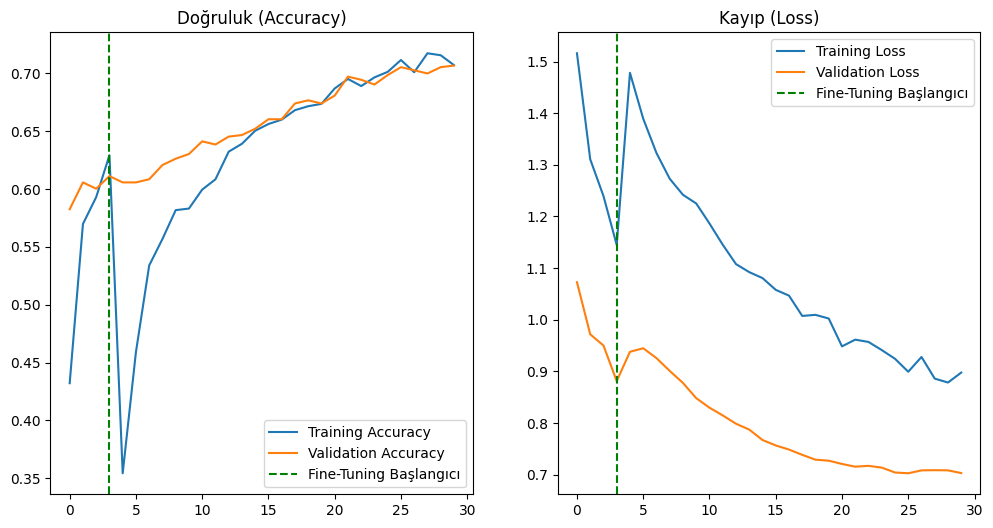

In [ ]:
# ==========================================
# 4. ADIM: SONUÇLARI BİRLEŞTİRME VE ÇİZME
# ==========================================
# İki aşamanın grafik verilerini birleştiriyoruz ki tek grafikte görelim
acc = history_warmup.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_warmup.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history_warmup.history['loss'] + history_finetune.history['loss']
val_loss = history_warmup.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# Geçiş noktasını çizgiyle gösterelim
plt.axvline(x=3, color='g', linestyle='--', label='Fine-Tuning Başlangıcı')
plt.title('Doğruluk (Accuracy)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=3, color='g', linestyle='--', label='Fine-Tuning Başlangıcı')
plt.title('Kayıp (Loss)')
plt.legend()
plt.show()

In [ ]:
print("LR:", float(model.optimizer.learning_rate.numpy()))
print("Loss:", model.loss)
print("Trainable layers:", sum(l.trainable for l in model.layers))
print("Class mode:", getattr(train_generator, "class_mode", None))


LR: 2.499999936844688e-06
Loss: sparse_categorical_crossentropy
Trainable layers: 242
Class mode: raw


In [ ]:
validation_generator.reset()
pred = model.predict(validation_generator, verbose=0)
y_pred = np.argmax(pred, axis=1)

print("pred len:", len(y_pred))
print("y_test len:", len(y_test.values))
print("val shuffle:", getattr(validation_generator, "shuffle", None))
print("pred class counts:", np.bincount(y_pred))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


pred len: 733
y_test len: 733
val shuffle: False
pred class counts: [383 125 107  63  55]


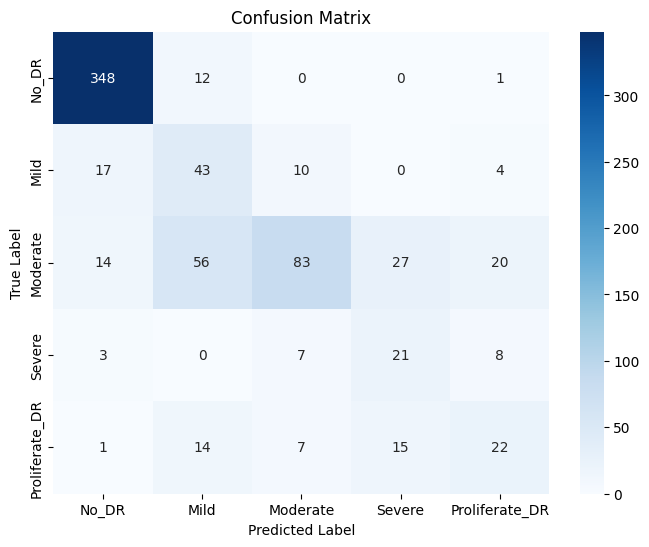

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score
import numpy as np

predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = y_test.values[:len(predicted_classes)]

kappa_score = cohen_kappa_score(
    true_classes,
    predicted_classes,
    weights="quadratic"
)

print(f"Quadratic Cohen's Kappa: {kappa_score:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step
Quadratic Cohen's Kappa: 0.7836
